<a href="https://colab.research.google.com/github/PMH2906/Deeplearning_system/blob/main/Resnet(adam_MNIST)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
import tqdm as tqdm
from torch.autograd import Variable

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                # expand chennel from 1 to 3 to fit 
                                # ResNet pretrained model
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                ]) 
batch_size = 256

# download dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(len(mnist_train), len(mnist_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
    shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
    shuffle=True, num_workers=0)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!
60000 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# print(models.resnet18())
class ResNetFeatrueExtractor18(nn.Module):
    def __init__(self, pretrained = True):
        super(ResNetFeatrueExtractor18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=pretrained)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

class ResClassifier(nn.Module):
    def __init__(self, dropout_p=0.5): #in_features=512
        super(ResClassifier, self).__init__()        
        self.fc = nn.Linear(512, 10)
    def forward(self, x):       
        out = self.fc(x)
        return out


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)

# calculate test accuracy
def test_accuracy(data_iter, netG, netF):
    """Evaluate testset accuracy of a model."""
    acc_sum,n = 0,0
    for (imgs, labels) in data_iter:
        # send data to the GPU if cuda is availabel
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        netG.eval()
        netF.eval()
        with torch.no_grad():
            labels = labels.long()
            acc_sum += torch.sum((torch.argmax(netF(netG(imgs)), dim=1) == labels)).float()
            n += labels.shape[0]
    return acc_sum.item()/n

In [4]:
#그래프
Loss=[]
Acc=[]
Val_Loss=[]
Val_Acc=[]

netG = ResNetFeatrueExtractor18(pretrained = True)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.Adam(netF.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 10):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible  
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)     
        
        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()
        
        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF) 
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))
    Loss.append(train_l_sum/n)
    Acc.append(train_acc_sum/n)
    Val_Acc.append(test_acc)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


235it [00:09, 23.54it/s]
3it [00:00, 26.28it/s]

epoch 1, loss 0.0009, train acc 0.935, test acc 0.980, time 10.8 sec


235it [00:09, 24.05it/s]
3it [00:00, 25.82it/s]

epoch 2, loss 0.0002, train acc 0.985, test acc 0.985, time 10.6 sec


235it [00:09, 24.04it/s]
3it [00:00, 26.39it/s]

epoch 3, loss 0.0001, train acc 0.993, test acc 0.987, time 10.6 sec


235it [00:09, 24.05it/s]
3it [00:00, 26.36it/s]

epoch 4, loss 0.0001, train acc 0.995, test acc 0.987, time 10.6 sec


235it [00:09, 24.06it/s]
3it [00:00, 26.26it/s]

epoch 5, loss 0.0000, train acc 0.997, test acc 0.989, time 10.6 sec


235it [00:09, 24.05it/s]
3it [00:00, 25.50it/s]

epoch 6, loss 0.0000, train acc 0.997, test acc 0.985, time 10.6 sec


235it [00:09, 24.06it/s]
3it [00:00, 25.83it/s]

epoch 7, loss 0.0000, train acc 0.998, test acc 0.988, time 10.6 sec


235it [00:09, 24.03it/s]
3it [00:00, 25.05it/s]

epoch 8, loss 0.0000, train acc 0.998, test acc 0.989, time 10.6 sec


235it [00:09, 24.05it/s]
3it [00:00, 26.13it/s]

epoch 9, loss 0.0000, train acc 0.998, test acc 0.988, time 10.6 sec


235it [00:09, 24.05it/s]


epoch 10, loss 0.0000, train acc 0.998, test acc 0.989, time 10.6 sec


In [5]:
netG = ResNetFeatrueExtractor18(pretrained = False)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.Adam(netF.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 10):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible  
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)     
        
        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()
        
        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF) 
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

235it [00:09, 23.99it/s]
3it [00:00, 26.03it/s]

epoch 1, loss 0.0009, train acc 0.927, test acc 0.974, time 10.6 sec


235it [00:09, 24.01it/s]
3it [00:00, 25.50it/s]

epoch 2, loss 0.0002, train acc 0.981, test acc 0.976, time 10.7 sec


235it [00:09, 24.03it/s]
3it [00:00, 24.97it/s]

epoch 3, loss 0.0001, train acc 0.990, test acc 0.981, time 10.6 sec


235it [00:09, 24.05it/s]
3it [00:00, 25.99it/s]

epoch 4, loss 0.0001, train acc 0.995, test acc 0.982, time 10.6 sec


235it [00:09, 24.02it/s]
3it [00:00, 26.18it/s]

epoch 5, loss 0.0000, train acc 0.997, test acc 0.984, time 10.6 sec


235it [00:09, 24.05it/s]
3it [00:00, 25.77it/s]

epoch 6, loss 0.0000, train acc 0.997, test acc 0.980, time 10.6 sec


235it [00:09, 24.02it/s]
3it [00:00, 25.77it/s]

epoch 7, loss 0.0000, train acc 0.996, test acc 0.975, time 10.7 sec


235it [00:09, 24.05it/s]
3it [00:00, 25.96it/s]

epoch 8, loss 0.0001, train acc 0.994, test acc 0.979, time 10.6 sec


235it [00:09, 24.04it/s]
3it [00:00, 26.17it/s]

epoch 9, loss 0.0001, train acc 0.994, test acc 0.973, time 10.6 sec


235it [00:09, 24.04it/s]


epoch 10, loss 0.0001, train acc 0.994, test acc 0.983, time 10.6 sec


In [6]:
import matplotlib.pyplot as plt

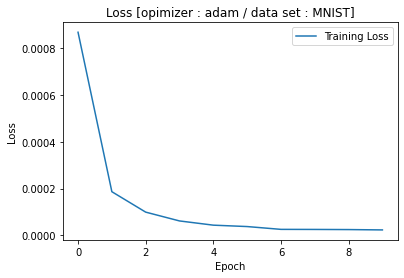

In [9]:
plt.plot(range(10),Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss [opimizer : adam / data set : MNIST]")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

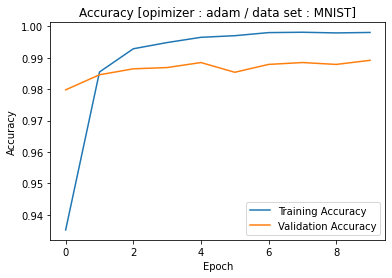

In [10]:
plt.plot(range(10),Acc)
plt.plot(range(10),Val_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy [opimizer : adam / data set : MNIST]")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()